Github: https://github.com/gdavidi/HealthCare-Project

Developers: 
* Itamar Hoshen 208728352
* Moshe Goldzand 312486046
* Gal Davidi 206555112

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.stats import chi2_contingency

In [50]:
# Load core tables
patients = pd.read_csv('PATIENTS.csv') # Patient demographics (age, gender, etc.)
admissions = pd.read_csv('ADMISSIONS.csv') # Admission details (admission/discharge times)
diagnoses_icd = pd.read_csv('DIAGNOSES_ICD.csv') # Patient diagnoses (ICD-9 codes)
d_icd_diagnoses = pd.read_csv('D_ICD_DIAGNOSES.csv') # ICD-9 code descriptions
chartevents = pd.read_csv('CHARTEVENTS.csv') # Vital signs (including BP measurements)
d_items = pd.read_csv('D_ITEMS.csv')
icustays = pd.read_csv('ICUSTAYS.csv') # ICU stays information

C:\Users\User\AppData\Local\Temp\ipykernel_33428\3412083022.py:6: DtypeWarning: Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  chartevents = pd.read_csv('CHARTEVENTS.csv') # Vital signs (including BP measurements)


# Creating the csv

In [51]:
# Our group was assigned to analyze patients that have CHF background and Diastolic BP vital signs/lab results.
# First, we will identify all of the relevant icd9_codes regarding CHF, in-order to find patients with CHF diagnoses.
d_icd_diagnoses

,row_id,icd9_code,short_title,long_title
0,1,01716,Erythem nod tb-oth test,Erythema nodosum with hypersensitivity reactio...
1,2,01720,TB periph lymph-unspec,"Tuberculosis of peripheral lymph nodes, unspec..."
2,3,01721,TB periph lymph-no exam,"Tuberculosis of peripheral lymph nodes, bacter..."
3,4,01722,TB periph lymph-exam unk,"Tuberculosis of peripheral lymph nodes, bacter..."
4,5,01723,TB periph lymph-micro dx,"Tuberculosis of peripheral lymph nodes, tuberc..."
...,...,...,...,...
14562,14563,V8712,Contact/exposure benzene,Contact with and (suspected) exposure to benzene
14563,14564,V8719,Cont/exp haz aromat NEC,Contact with and (suspected) exposure to other...
14564,14565,V872,Cont/exp hazard chem NEC,Contact with and (suspected) exposure to other...
14565,14566,V8731,Contact/exposure mold,Contact with and (suspected) exposure to mold


In [52]:
# According to google, CHF icd9_codes often start with 428xxx.
chf_codes = d_icd_diagnoses[d_icd_diagnoses['icd9_code'].str.startswith('428')][['icd9_code','long_title']] # Looking for all of the codes that start with 428 (CHF)
chf_codes

,icd9_code,long_title
4472,4280,"Congestive heart failure, unspecified"
4473,4281,Left heart failure
4474,42820,"Systolic heart failure, unspecified"
4475,42821,Acute systolic heart failure
4476,42822,Chronic systolic heart failure
4477,42823,Acute on chronic systolic heart failure
4478,42830,"Diastolic heart failure, unspecified"
4479,42831,Acute diastolic heart failure
4480,42832,Chronic diastolic heart failure
4481,42833,Acute on chronic diastolic heart failure


In [53]:
# Find the subject_id that correspond to the relevant icd9_codes (CHF)
diagnosed_patients = diagnoses_icd.merge(chf_codes, on='icd9_code').drop_duplicates()
print(f"We have found {len(diagnosed_patients['subject_id'].unique())} subject ids that have CHF")

We have found 35 subject ids that have CHF


In [54]:
# To find which subject_ids are related to diastolic blood pressure, we will first need to find the item_ids that are related to diastolic blood pressure.
# To achieve that, we will use the D_ITEMS dataset, that contains both item_ids and their labels/abbreviation.
diastolic_item_id = d_items[d_items['label'].str.contains('diastolic', case=False) | d_items['abbreviation'].str.contains('dbp' ,case=False)]
dbp_labels_abbreviation = diastolic_item_id[diastolic_item_id['label'].str.contains('Blood Pressure', case = False) | diastolic_item_id['label'].str.contains('bp', case = False) | diastolic_item_id['abbreviation'].str.contains('bp', case = False)]
dbp_labels_abbreviation 

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
4826,4827,8364,ABP [Diastolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4830,4831,8368,Arterial BP [Diastolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4902,4903,8440,Manual BP [Diastolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4903,4904,8441,NBP [Diastolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4906,4907,8444,Orthostat BP sitting [Diastolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4907,4908,8445,OrthostatBP standing [Diastolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4908,4909,8446,Orthostatic BP lying [Diastolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4952,4953,8502,BP Cuff [Diastolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4953,4954,8503,BP Left Arm [Diastolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN
4954,4955,8504,BP Left Leg [Diastolic],NaN,carevue,chartevents,NaN,NaN,NaN,NaN


In [55]:
chf_dbp_subject_ids = chartevents.merge(dbp_labels_abbreviation, on='itemid').drop_duplicates().merge(diagnosed_patients, on='subject_id').drop_duplicates()
chf_dbp_subject_ids

,row_id_x,subject_id,hadm_id_x,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,...,linksto,category,unitname,param_type,conceptid,row_id,hadm_id_y,seq_num,icd9_code,long_title
0,5353122,40204,175237,285369.0,220180,2155-12-16 18:26:00,2155-12-16 18:29:00,19681,76.0,76.0,...,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,380042,175237,3,42822,Chronic systolic heart failure
1,5353122,40204,175237,285369.0,220180,2155-12-16 18:26:00,2155-12-16 18:29:00,19681,76.0,76.0,...,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,380048,175237,9,4280,"Congestive heart failure, unspecified"
2,5353130,40204,175237,285369.0,220180,2155-12-16 19:00:00,2155-12-16 20:33:00,21297,67.0,67.0,...,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,380042,175237,3,42822,Chronic systolic heart failure
3,5353130,40204,175237,285369.0,220180,2155-12-16 19:00:00,2155-12-16 20:33:00,21297,67.0,67.0,...,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,380048,175237,9,4280,"Congestive heart failure, unspecified"
4,5353136,40204,175237,285369.0,220180,2155-12-16 20:00:00,2155-12-16 20:33:00,21297,60.0,60.0,...,chartevents,Routine Vital Signs,mmHg,Numeric,NaN,380042,175237,3,42822,Chronic systolic heart failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10807,235415785,10126,160445,249805.0,8368,2171-08-16 17:00:00,2171-08-16 17:13:00,19263,45,45.0,...,chartevents,NaN,NaN,NaN,NaN,113468,160445,13,4280,"Congestive heart failure, unspecified"
10808,235415794,10126,160445,249805.0,8368,2171-08-16 18:00:00,2171-08-16 18:35:00,16866,42,42.0,...,chartevents,NaN,NaN,NaN,NaN,113468,160445,13,4280,"Congestive heart failure, unspecified"
10809,235415796,10126,160445,249805.0,8368,2171-08-16 19:00:00,2171-08-16 19:57:00,16866,39,39.0,...,chartevents,NaN,NaN,NaN,NaN,113468,160445,13,4280,"Congestive heart failure, unspecified"
10810,235415814,10126,160445,249805.0,8368,2171-08-16 20:00:00,2171-08-16 19:57:00,16866,37,37.0,...,chartevents,NaN,NaN,NaN,NaN,113468,160445,13,4280,"Congestive heart failure, unspecified"


In [56]:
# Now that have the relevent information(rows), we will merge (aka INNER JOIN) it with the patients data.
# Before merging we will check that the shared features (columns) between two datasets that we want to merge are the same type.
# If not, we will change their type to match.

# Datas to merge:
# chf_dbp_subject_ids
# patients
# admissions

chf_dbp_subject_ids.dtypes    

row_id_x          int64
subject_id        int64
hadm_id_x         int64
icustay_id      float64
itemid            int64
charttime        object
storetime        object
cgid              int64
value            object
valuenum        float64
valueuom         object
warning         float64
error           float64
resultstatus     object
stopped          object
row_id_y          int64
label            object
abbreviation     object
dbsource         object
linksto          object
category         object
unitname         object
param_type       object
conceptid       float64
row_id            int64
hadm_id_y         int64
seq_num           int64
icd9_code        object
long_title       object
dtype: object

In [57]:
try:
	len(chf_dbp_subject_ids[chf_dbp_subject_ids['value'].astype(float) != chf_dbp_subject_ids['valuenum']])
	# The two columns are identical, therefore we will remove one of them.
	chf_dbp_subject_ids = chf_dbp_subject_ids.drop(labels='valuenum', axis=1)
except:
    pass

In [58]:
patients.dtypes 
# subject_id
# gender
# dob
# dod
# expire_flag    

row_id          int64
subject_id      int64
gender         object
dob            object
dod            object
dod_hosp       object
dod_ssn        object
expire_flag     int64
dtype: object

In [59]:
admissions.dtypes
# subject_id
# addmittime
# dischtime
# deathtime
# ethnicity

row_id                   int64
subject_id               int64
hadm_id                  int64
admittime               object
dischtime               object
deathtime               object
admission_type          object
admission_location      object
discharge_location      object
insurance               object
language                object
religion                object
marital_status          object
ethnicity               object
edregtime               object
edouttime               object
diagnosis               object
hospital_expire_flag     int64
has_chartevents_data     int64
dtype: object

In [60]:
df = chf_dbp_subject_ids.merge(patients[['subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'expire_flag']], on="subject_id").drop_duplicates().merge(admissions[['subject_id','ethnicity']], on="subject_id").drop_duplicates().merge(icustays[["subject_id", "intime", "outtime"]], on='subject_id').drop_duplicates()
df

,row_id_x,subject_id,hadm_id_x,icustay_id,itemid,charttime,storetime,cgid,value,valueuom,...,icd9_code,long_title,gender,dob,dod,dod_hosp,expire_flag,ethnicity,intime,outtime
0,5353122,40204,175237,285369.0,220180,2155-12-16 18:26:00,2155-12-16 18:29:00,19681,76.0,mmHg,...,42822,Chronic systolic heart failure,M,2079-08-17 00:00:00,2156-02-08 00:00:00,2156-02-08 00:00:00,1,BLACK/AFRICAN AMERICAN,2155-12-16 16:21:06,2155-12-17 12:58:21
1,5353122,40204,175237,285369.0,220180,2155-12-16 18:26:00,2155-12-16 18:29:00,19681,76.0,mmHg,...,4280,"Congestive heart failure, unspecified",M,2079-08-17 00:00:00,2156-02-08 00:00:00,2156-02-08 00:00:00,1,BLACK/AFRICAN AMERICAN,2155-12-16 16:21:06,2155-12-17 12:58:21
2,5353130,40204,175237,285369.0,220180,2155-12-16 19:00:00,2155-12-16 20:33:00,21297,67.0,mmHg,...,42822,Chronic systolic heart failure,M,2079-08-17 00:00:00,2156-02-08 00:00:00,2156-02-08 00:00:00,1,BLACK/AFRICAN AMERICAN,2155-12-16 16:21:06,2155-12-17 12:58:21
3,5353130,40204,175237,285369.0,220180,2155-12-16 19:00:00,2155-12-16 20:33:00,21297,67.0,mmHg,...,4280,"Congestive heart failure, unspecified",M,2079-08-17 00:00:00,2156-02-08 00:00:00,2156-02-08 00:00:00,1,BLACK/AFRICAN AMERICAN,2155-12-16 16:21:06,2155-12-17 12:58:21
4,5353136,40204,175237,285369.0,220180,2155-12-16 20:00:00,2155-12-16 20:33:00,21297,60.0,mmHg,...,42822,Chronic systolic heart failure,M,2079-08-17 00:00:00,2156-02-08 00:00:00,2156-02-08 00:00:00,1,BLACK/AFRICAN AMERICAN,2155-12-16 16:21:06,2155-12-17 12:58:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19412,235415785,10126,160445,249805.0,8368,2171-08-16 17:00:00,2171-08-16 17:13:00,19263,45,mmHg,...,4280,"Congestive heart failure, unspecified",F,2127-06-04 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,1,WHITE,2171-07-12 16:13:00,2171-08-17 01:58:23
19413,235415794,10126,160445,249805.0,8368,2171-08-16 18:00:00,2171-08-16 18:35:00,16866,42,mmHg,...,4280,"Congestive heart failure, unspecified",F,2127-06-04 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,1,WHITE,2171-07-12 16:13:00,2171-08-17 01:58:23
19414,235415796,10126,160445,249805.0,8368,2171-08-16 19:00:00,2171-08-16 19:57:00,16866,39,mmHg,...,4280,"Congestive heart failure, unspecified",F,2127-06-04 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,1,WHITE,2171-07-12 16:13:00,2171-08-17 01:58:23
19415,235415814,10126,160445,249805.0,8368,2171-08-16 20:00:00,2171-08-16 19:57:00,16866,37,mmHg,...,4280,"Congestive heart failure, unspecified",F,2127-06-04 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,1,WHITE,2171-07-12 16:13:00,2171-08-17 01:58:23


In [61]:
# Removing duplicates & unnecessary columns.
df = df[['subject_id', 'value', 'valueuom', 'label', 'icd9_code', 'long_title', 'gender', 'dob', 'dod', 'dod_hosp','expire_flag', 'ethnicity', 'intime', 'outtime']].drop_duplicates() 
df

,subject_id,value,valueuom,label,icd9_code,long_title,gender,dob,dod,dod_hosp,expire_flag,ethnicity,intime,outtime
0,40204,76.0,mmHg,Non Invasive Blood Pressure diastolic,42822,Chronic systolic heart failure,M,2079-08-17 00:00:00,2156-02-08 00:00:00,2156-02-08 00:00:00,1,BLACK/AFRICAN AMERICAN,2155-12-16 16:21:06,2155-12-17 12:58:21
1,40204,76.0,mmHg,Non Invasive Blood Pressure diastolic,4280,"Congestive heart failure, unspecified",M,2079-08-17 00:00:00,2156-02-08 00:00:00,2156-02-08 00:00:00,1,BLACK/AFRICAN AMERICAN,2155-12-16 16:21:06,2155-12-17 12:58:21
2,40204,67.0,mmHg,Non Invasive Blood Pressure diastolic,42822,Chronic systolic heart failure,M,2079-08-17 00:00:00,2156-02-08 00:00:00,2156-02-08 00:00:00,1,BLACK/AFRICAN AMERICAN,2155-12-16 16:21:06,2155-12-17 12:58:21
3,40204,67.0,mmHg,Non Invasive Blood Pressure diastolic,4280,"Congestive heart failure, unspecified",M,2079-08-17 00:00:00,2156-02-08 00:00:00,2156-02-08 00:00:00,1,BLACK/AFRICAN AMERICAN,2155-12-16 16:21:06,2155-12-17 12:58:21
4,40204,60.0,mmHg,Non Invasive Blood Pressure diastolic,42822,Chronic systolic heart failure,M,2079-08-17 00:00:00,2156-02-08 00:00:00,2156-02-08 00:00:00,1,BLACK/AFRICAN AMERICAN,2155-12-16 16:21:06,2155-12-17 12:58:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19155,10126,43,mmHg,Arterial BP [Diastolic],4280,"Congestive heart failure, unspecified",F,2127-06-04 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,1,WHITE,2171-07-12 16:13:00,2171-08-17 01:58:23
19159,10126,44,mmHg,Arterial BP [Diastolic],4280,"Congestive heart failure, unspecified",F,2127-06-04 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,1,WHITE,2171-07-12 16:13:00,2171-08-17 01:58:23
19402,10126,37,mmHg,Arterial BP [Diastolic],4280,"Congestive heart failure, unspecified",F,2127-06-04 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,1,WHITE,2171-07-12 16:13:00,2171-08-17 01:58:23
19409,10126,34,mmHg,Arterial BP [Diastolic],4280,"Congestive heart failure, unspecified",F,2127-06-04 00:00:00,2171-08-16 00:00:00,2171-08-16 00:00:00,1,WHITE,2171-07-12 16:13:00,2171-08-17 01:58:23


# Understanding the data and processing it

In [62]:
df.info()
df['value'] = df['value'].astype(float)

<class 'pandas.core.frame.DataFrame'>
Index: 3860 entries, 0 to 19416
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   subject_id   3860 non-null   int64 
 1   value        3860 non-null   object
 2   valueuom     3860 non-null   object
 3   label        3860 non-null   object
 4   icd9_code    3860 non-null   object
 5   long_title   3860 non-null   object
 6   gender       3860 non-null   object
 7   dob          3860 non-null   object
 8   dod          3860 non-null   object
 9   dod_hosp     2573 non-null   object
 10  expire_flag  3860 non-null   int64 
 11  ethnicity    3860 non-null   object
 12  intime       3860 non-null   object
 13  outtime      3860 non-null   object
dtypes: int64(2), object(12)
memory usage: 452.3+ KB


### Target Variable -> Creating died_in_icu column that will hold a True/False value to whether the patient died while staying at the ICU or not.

In [63]:
# Checking for missing values:
df.isna().sum()
# Missing values only at column dod_hosp, which is ok because it means the patient didn't die at the hospital.

subject_id        0
value             0
valueuom          0
label             0
icd9_code         0
long_title        0
gender            0
dob               0
dod               0
dod_hosp       1287
expire_flag       0
ethnicity         0
intime            0
outtime           0
dtype: int64

In [64]:
try:
    # Converting columns dob, dod, dod_hosp, intime, outtime to datetime
	df["dob"] = pd.to_datetime(df["dob"])
	df["dod"] = pd.to_datetime(df["dod"])
	df["dod_hosp"] = pd.to_datetime(df["dod_hosp"])
	df["intime"] = pd.to_datetime(df["intime"])
	df["outtime"] = pd.to_datetime(df["outtime"])
 
	# Check if death occurred during ANY ICU stay and creating new boolean column "died_in_icu" (No=False, Yes=True)
	df["died_in_icu"] = (df["dod_hosp"] >= df["intime"]) & (df["dod_hosp"] <= df["outtime"]) # If dod_hosp hold a missing value, died_in_icu will hold False.
		# Logic:
		# If the time&date the patient died was after the time the ICU department received him/her and before the time&date the patient was discharged from the ICU department, it means the patient died while staying at the ICU.
except:
    pass

In [65]:
df[["died_in_icu"]].value_counts()

died_in_icu
False          3064
True            796
Name: count, dtype: int64

In [66]:
df.shape

(3860, 15)

In [67]:
# We can now remove columns: dod_hosp, intime and outtime.
try:
    df = df.drop(labels=['dod_hosp', 'intime', 'outtime'], axis=1).drop_duplicates()
except:
    pass    

In [68]:
df 

,subject_id,value,valueuom,label,icd9_code,long_title,gender,dob,dod,expire_flag,ethnicity,died_in_icu
0,40204,76.0,mmHg,Non Invasive Blood Pressure diastolic,42822,Chronic systolic heart failure,M,2079-08-17,2156-02-08,1,BLACK/AFRICAN AMERICAN,False
1,40204,76.0,mmHg,Non Invasive Blood Pressure diastolic,4280,"Congestive heart failure, unspecified",M,2079-08-17,2156-02-08,1,BLACK/AFRICAN AMERICAN,False
2,40204,67.0,mmHg,Non Invasive Blood Pressure diastolic,42822,Chronic systolic heart failure,M,2079-08-17,2156-02-08,1,BLACK/AFRICAN AMERICAN,False
3,40204,67.0,mmHg,Non Invasive Blood Pressure diastolic,4280,"Congestive heart failure, unspecified",M,2079-08-17,2156-02-08,1,BLACK/AFRICAN AMERICAN,False
4,40204,60.0,mmHg,Non Invasive Blood Pressure diastolic,42822,Chronic systolic heart failure,M,2079-08-17,2156-02-08,1,BLACK/AFRICAN AMERICAN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
19155,10126,43.0,mmHg,Arterial BP [Diastolic],4280,"Congestive heart failure, unspecified",F,2127-06-04,2171-08-16,1,WHITE,True
19159,10126,44.0,mmHg,Arterial BP [Diastolic],4280,"Congestive heart failure, unspecified",F,2127-06-04,2171-08-16,1,WHITE,True
19402,10126,37.0,mmHg,Arterial BP [Diastolic],4280,"Congestive heart failure, unspecified",F,2127-06-04,2171-08-16,1,WHITE,True
19409,10126,34.0,mmHg,Arterial BP [Diastolic],4280,"Congestive heart failure, unspecified",F,2127-06-04,2171-08-16,1,WHITE,True


### Creating Age column

In [69]:
# To understand what is the age, we will make use of the date of birth and death(if exists).
# Even though the dates (years) are not realistic, we can still calculate the age by calculating the gap between date of death and date of birth.

# Calculate age using relativedelta between dob and dod (or current date if alive)
def calculate_age(row):
    end_date = row['dod'] if pd.notna(row['dod']) else pd.to_datetime('today') # handling NaN for date of death
    if pd.isna(row['dob']): # handling NaN for date of birth
        return np.nan
    return relativedelta(end_date, row['dob']).years

# Apply the function to each row
df['age'] = df.apply(calculate_age, axis=1)

### Organizing the data

In [70]:
df['valueuom'].value_counts()
# Because all of the unit of measurements are mmHg, which describes heart beats, we can safely remove this column and the value column's name to blood_pressure_value.

valueuom
mmHg    2824
Name: count, dtype: int64

In [71]:
try:
    # Removing dob & dod columns
	df = df.drop(labels=['dob','dod', 'icd9_code', 'valueuom'], axis=1).drop_duplicates()
    
    # Ordering and Renaming the columns
	df = df[['subject_id', 'age', 'gender', 'ethnicity', 'label', 'value', 'long_title', 'expire_flag', 'died_in_icu']]
	df = df.rename(columns={'value': 'blood_pressure_value', 'label': 'vital_signs', 'long_title': 'background_disease' })
except:
    pass

In [72]:
df

,subject_id,age,gender,ethnicity,vital_signs,blood_pressure_value,background_disease,expire_flag,died_in_icu
0,40204,76,M,BLACK/AFRICAN AMERICAN,Non Invasive Blood Pressure diastolic,76.0,Chronic systolic heart failure,1,False
1,40204,76,M,BLACK/AFRICAN AMERICAN,Non Invasive Blood Pressure diastolic,76.0,"Congestive heart failure, unspecified",1,False
2,40204,76,M,BLACK/AFRICAN AMERICAN,Non Invasive Blood Pressure diastolic,67.0,Chronic systolic heart failure,1,False
3,40204,76,M,BLACK/AFRICAN AMERICAN,Non Invasive Blood Pressure diastolic,67.0,"Congestive heart failure, unspecified",1,False
4,40204,76,M,BLACK/AFRICAN AMERICAN,Non Invasive Blood Pressure diastolic,60.0,Chronic systolic heart failure,1,False
...,...,...,...,...,...,...,...,...,...
19155,10126,44,F,WHITE,Arterial BP [Diastolic],43.0,"Congestive heart failure, unspecified",1,True
19159,10126,44,F,WHITE,Arterial BP [Diastolic],44.0,"Congestive heart failure, unspecified",1,True
19402,10126,44,F,WHITE,Arterial BP [Diastolic],37.0,"Congestive heart failure, unspecified",1,True
19409,10126,44,F,WHITE,Arterial BP [Diastolic],34.0,"Congestive heart failure, unspecified",1,True


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2824 entries, 0 to 19416
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   subject_id            2824 non-null   int64  
 1   age                   2824 non-null   int64  
 2   gender                2824 non-null   object 
 3   ethnicity             2824 non-null   object 
 4   vital_signs           2824 non-null   object 
 5   blood_pressure_value  2824 non-null   float64
 6   background_disease    2824 non-null   object 
 7   expire_flag           2824 non-null   int64  
 8   died_in_icu           2824 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(4)
memory usage: 201.3+ KB


### EDA

In [74]:
print(f'Our data contains {len(df['subject_id'].unique())} patients')

Our data contains 35 patients


In [75]:
df['expire_flag'].unique() # All are dead

array([1])

##### Vital Signs

In [76]:
# Checking for unique values ​​in a 'vital_signs' column 
df['vital_signs'].unique()

array(['Non Invasive Blood Pressure diastolic',
       'Arterial Blood Pressure diastolic',
       'Manual Blood Pressure Diastolic Left',
       'Manual Blood Pressure Diastolic Right', 'NBP [Diastolic]',
       'Arterial BP [Diastolic]', 'Manual BP [Diastolic]',
       'Arterial BP #2 [Diastolic]'], dtype=object)

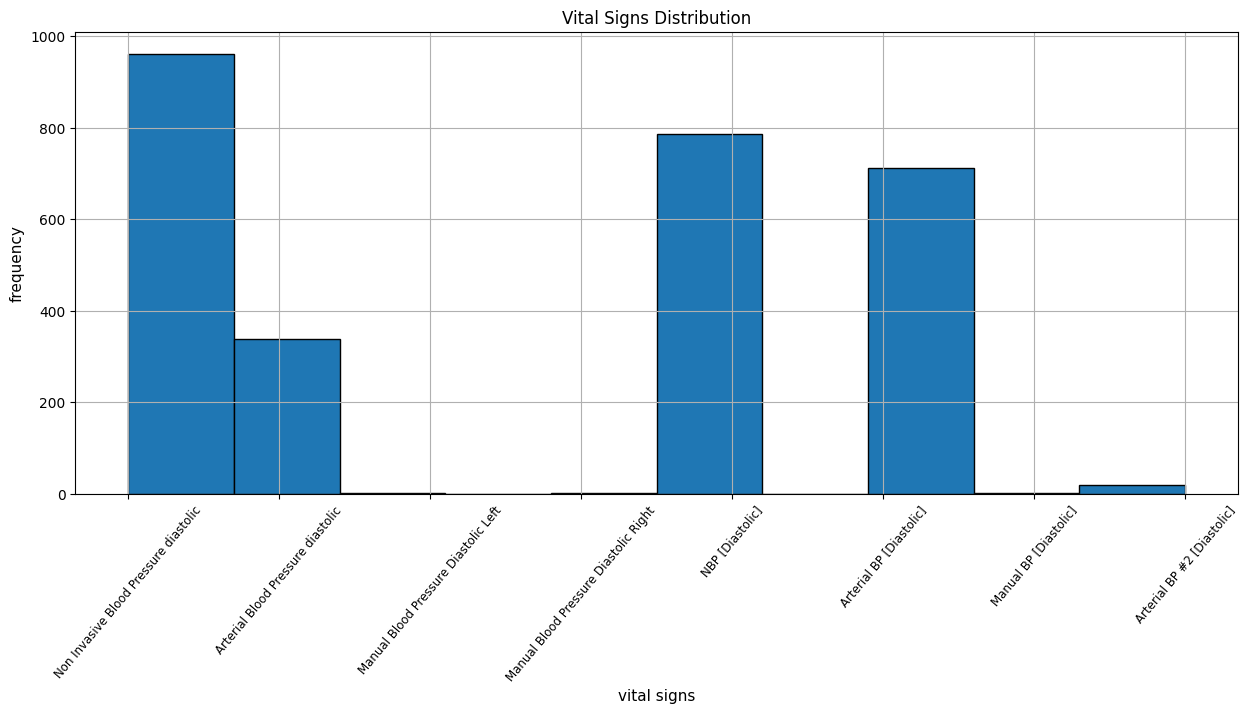

In [77]:
plt.figure(figsize=(15, 6)) 
df['vital_signs'].hist(edgecolor='black')
plt.xticks(fontsize=8.5, rotation=50)
plt.title('Vital Signs Distribution', fontsize=12)
plt.xlabel('vital signs', fontsize=11)
plt.ylabel('frequency', fontsize=11)
plt.show()

##### Age

In [78]:
# Summarizing descriptive statistics for the 'age' column (count, mean, std, min, quartiles, max)
df['age'].describe()
# Mean age = 89.9
# Median age = 83

count    2824.000000
mean       89.670326
std        54.990979
min        41.000000
25%        76.000000
50%        83.000000
75%        87.000000
max       302.000000
Name: age, dtype: float64

In [79]:
df.groupby('subject_id')[['age']].first()
# There 3 unrealistic ages (>120), we will replace them with the median value.

,age
subject_id,
10006,71
10027,82
10029,79
10032,88
10038,91
10040,88
10042,74
10043,81
10045,68


<Figure size 1000x500 with 0 Axes>

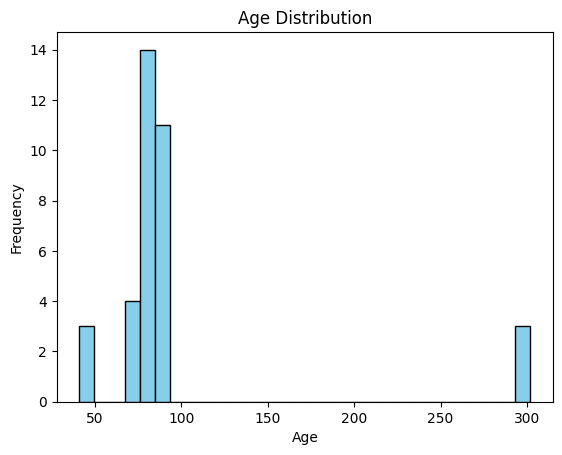

In [80]:
plt.figure(figsize=(10, 5))
df.groupby('subject_id')[['age']].first().hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

In [81]:
# Calculate mean of valid ages (120 and below)
valid_age_median = df.loc[df['age'] <= 120, 'age'].median()

# Replace ages above 120 with the mean
df.loc[df['age'] > 120, 'age'] = valid_age_median

<Figure size 1000x500 with 0 Axes>

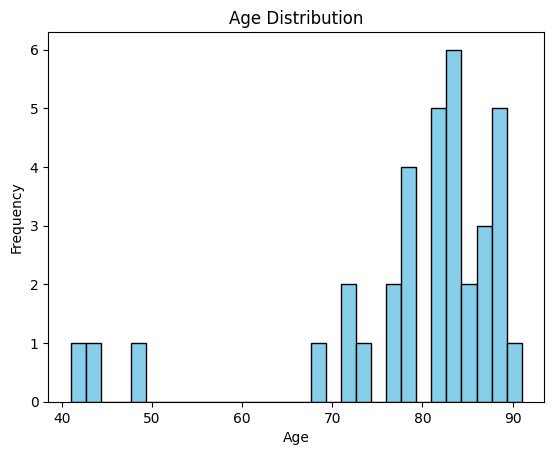

In [82]:
plt.figure(figsize=(10, 5))
df.groupby('subject_id')[['age']].first().hist(bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

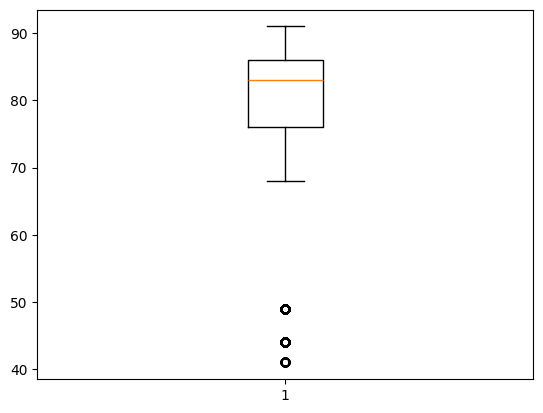

In [83]:
plt.boxplot(df['age'])
plt.show

In [84]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)

Upper_inference = Q3+1.5*(Q3-Q1)
Lower_inference = Q1-1.5*(Q3-Q1)
print(f'''Upper inference: {Upper_inference}
Lower inference {Lower_inference}\n
We can see that there are some very "young" patients, so young that they are identified as outliers by the statistic's method.
We will want to first identify if there is some common reasoning for the death of these patients at such age, and might remove them later to further examine the age's within the "normal" scale using statistics.
Everything will be taken of only after we will deal with the rest of the columns first (outlier's wise).''')

Upper inference: 101.0
Lower inference 61.0

We can see that there are some very "young" patients, so young that they are identified as outliers by the statistic's method.
We will want to first identify if there is some common reasoning for the death of these patients at such age, and might remove them later to further examine the age's within the "normal" scale using statistics.
Everything will be taken of only after we will deal with the rest of the columns first (outlier's wise).


##### Gender

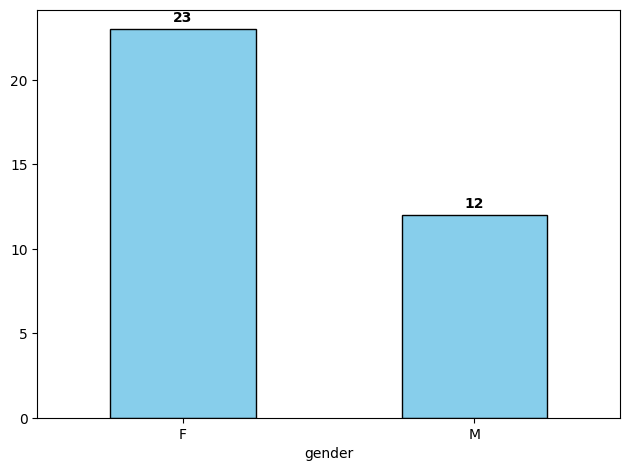

Looks like the condition is more common in Females than it is in Males, almost double the amount.


In [85]:
df.groupby('subject_id')['gender'].first().value_counts().plot.bar(color='skyblue', edgecolor='black')
plt.gca().bar_label(plt.gca().containers[0], label_type='edge', padding=3, fontsize=10, fontweight='bold')
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()
print('Looks like the condition is more common in Females than it is in Males, almost double the amount.')

##### Ethnicity

In [86]:
df['ethnicity']

0        BLACK/AFRICAN AMERICAN
1        BLACK/AFRICAN AMERICAN
2        BLACK/AFRICAN AMERICAN
3        BLACK/AFRICAN AMERICAN
4        BLACK/AFRICAN AMERICAN
                  ...          
19155                     WHITE
19159                     WHITE
19402                     WHITE
19409                     WHITE
19416                     WHITE
Name: ethnicity, Length: 2824, dtype: object

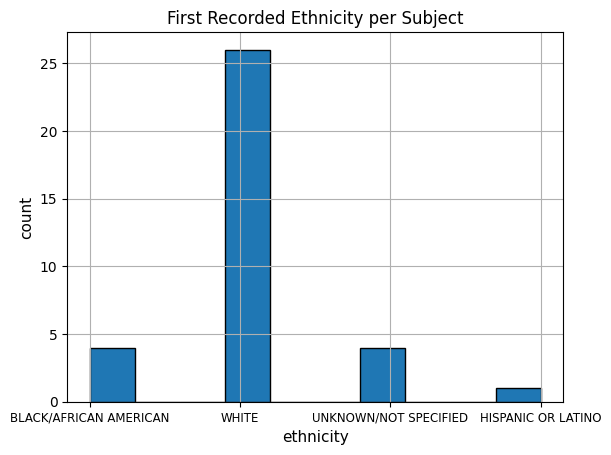

The condition is more common in white ethnicity


In [87]:
# Plotting the distribution of ethnicity using a histogram
df.groupby('subject_id')['ethnicity'].first().hist(edgecolor='black')
plt.xticks(fontsize=8.5)
plt.title('First Recorded Ethnicity per Subject', fontsize=12)
plt.xlabel('ethnicity', fontsize=11)
plt.ylabel('count', fontsize=11)
plt.show()
print('The condition is more common in white ethnicity')


##### Blood Pressure Value (charts value)

In [88]:
# Summarizing descriptive statistics for the 'blood_pressure_value' column (count, mean, std, min, quartiles, max)
df['blood_pressure_value'].describe()
# Mean = 56.1
# Median = 55

count    2824.000000
mean       56.312677
std        16.538418
min         0.000000
25%        45.000000
50%        55.000000
75%        66.000000
max       155.000000
Name: blood_pressure_value, dtype: float64

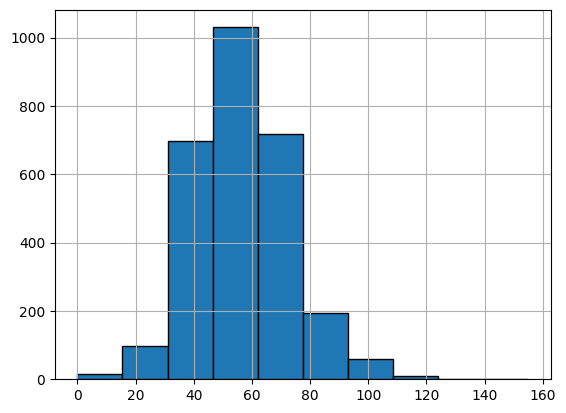

Normal distributed, capped at 0 and ~120


In [89]:
# Plotting the distribution of blood pressure values using a histogram
df['blood_pressure_value'].hist(edgecolor='black')
plt.show()
print('Normal distributed, capped at 0 and ~120')

In [90]:
df.groupby('subject_id')['died_in_icu'].first().value_counts()

died_in_icu
False    29
True      6
Name: count, dtype: int64

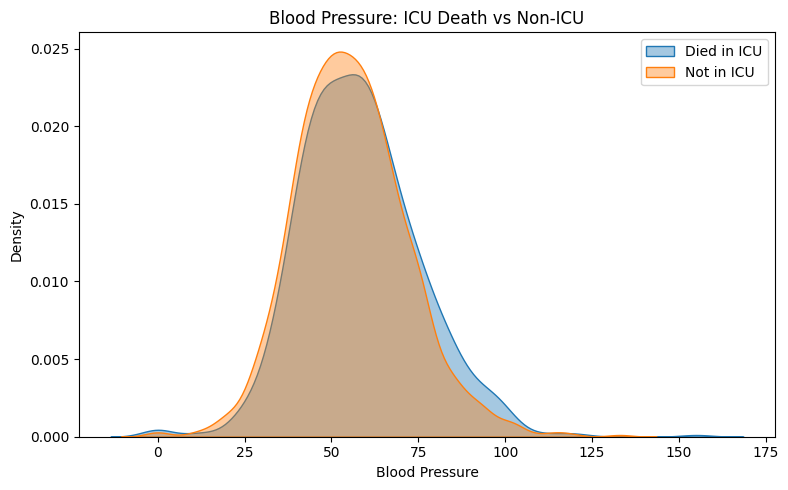

Looks like normal distribution.
Normaly, we would want to check the distribution using tests, such as Kolmogorov-Smirnov, but considering we have such a small amount of sample the tests are not valied.
Therefore, we would completly lean on the visual graph.


In [91]:
# Plotting Kernel Density Estimations (KDE) of blood pressure values for patients who died in ICU vs. those who did not.
# KDE provides a smooth estimate of the underlying distribution of heart rate values for each group,
# making it easier to compare patterns, central tendencies, and spread between the two groups.
# 'fill=True' adds transparency for visual clarity, and separating the two plots allows for direct visual comparison.

plt.figure(figsize=(8, 5))
sns.kdeplot(data=df[df['died_in_icu'] == True]['blood_pressure_value'], label='Died in ICU', fill=True, alpha=0.4)
sns.kdeplot(data=df[df['died_in_icu'] == False]['blood_pressure_value'], label='Not in ICU', fill=True, alpha=0.4)

plt.title('Blood Pressure: ICU Death vs Non-ICU')
plt.xlabel('Blood Pressure')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()
print('''Looks like normal distribution.
Normaly, we would want to check the distribution using tests, such as Kolmogorov-Smirnov, but considering we have such a small amount of sample the tests are not valied.
Therefore, we would completly lean on the visual graph.''')

In [92]:
# To assess whether "blood pressure" and "died in icu" are statistically different/similar, meaning they have some sort of correlation, we will use logistic regression.
# The reason we use logistic regression and not something like t-test is because 1 group (blood pressure) is numerical, while the other (died in icu) is binary.
X = sm.add_constant(df['blood_pressure_value'])
model = sm.Logit(df['died_in_icu'], X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.592529
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            died_in_icu   No. Observations:                 2824
Model:                          Logit   Df Residuals:                     2822
Method:                           MLE   Df Model:                            1
Date:                Mon, 07 Apr 2025   Pseudo R-squ.:                0.003668
Time:                        00:21:15   Log-Likelihood:                -1673.3
converged:                       True   LL-Null:                       -1679.5
Covariance Type:            nonrobust   LLR p-value:                 0.0004479
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.4373      0.150     -9.565      0.000      -1.732      -1.143

1. **Statistical significance**:  
   - "Higher blood pressure was significantly associated with increased ICU mortality (p=0.000)."  

2. **Practical interpretation**:
   - "However, each 1 mmHg increase raised odds of death by approximately 0.88% (OR = 1.0088), suggesting limited       clinical   impact."

3. **Model context**:  
   - "Blood pressure explained just 0.37% of mortality variance (Pseudo R² = 0.0037), indicating that other factors likely have a greater influence."



##### Vital Signs & Died in ICU statistic test

Chi-square test between vital signs category and ICU death:
Chi2 = 273.0644960441025
p-value = 3.382800454775362e-55
died_in_icu                                 False       True 
vital_signs                                                  
Arterial BP #2 [Diastolic]               0.000000  100.000000
Arterial BP [Diastolic]                 51.753156   48.246844
Arterial Blood Pressure diastolic       76.923077   23.076923
Manual BP [Diastolic]                    0.000000  100.000000
Manual Blood Pressure Diastolic Left   100.000000    0.000000
Manual Blood Pressure Diastolic Right  100.000000    0.000000
NBP [Diastolic]                         74.936387   25.063613
Non Invasive Blood Pressure diastolic   83.783784   16.216216


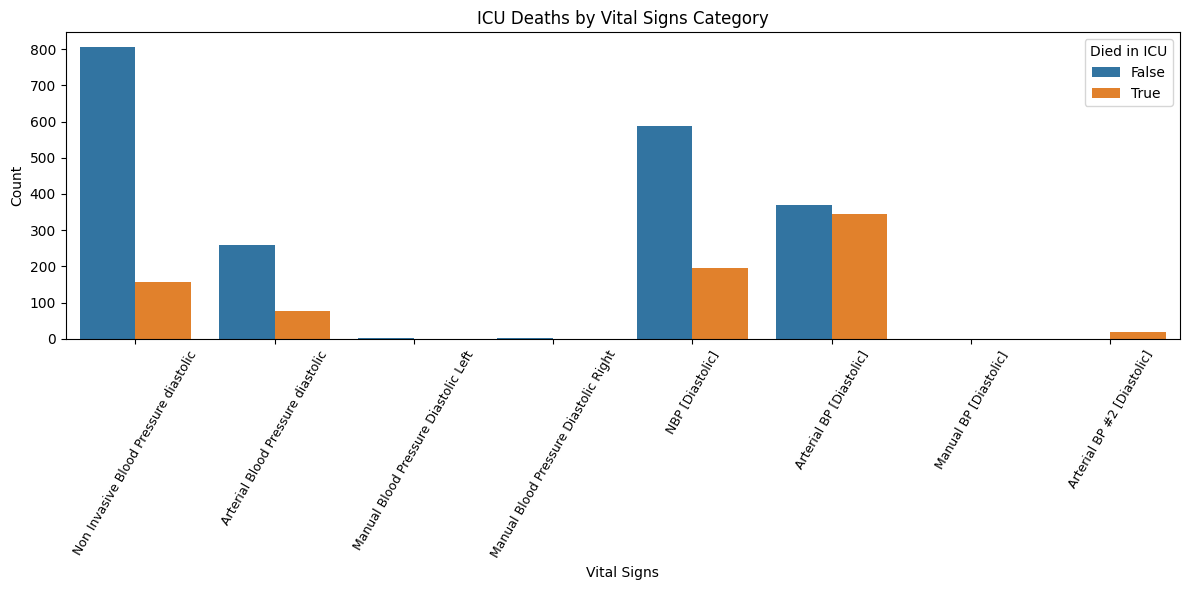

In [93]:
# Create a contingency table: counts of patients in each combination of vital_signs category and ICU outcome
contingency_table = pd.crosstab(df['vital_signs'], df['died_in_icu'])

# Perform the Chi-Square test of independence
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print test results
print("Chi-square test between vital signs category and ICU death:")
print("Chi2 =", chi2)
print("p-value =", p)

# Show the percentage of deaths/survivals within each vital_signs category
# Normalizing by index gives row-wise percentages
print(pd.crosstab(df['vital_signs'], df['died_in_icu'], normalize='index') * 100)

# Create a bar plot to visualize the distribution of ICU deaths and survivals per vital_signs category
plt.figure(figsize=(12, 6))
sns.countplot(x='vital_signs', hue='died_in_icu', data=df)
plt.title('ICU Deaths by Vital Signs Category')
plt.xlabel('Vital Signs')
plt.ylabel('Count')
plt.legend(title='Died in ICU')
plt.xticks(rotation=60, fontsize=9)
plt.tight_layout()
plt.show()



##### Interpretation:
The Chi-square test revealed a statistically significant association between the type of blood pressure measurement
and ICU mortality (Chi² = 273.06, p < 0.00001).
Summary of mortality rates by measurement method:
- Arterial BP #2 and Manual BP: 100% mortality (may indicate critical condition or very small sample size)
- Arterial BP: ~48% mortality
- NBP (Non-invasive BP): ~25% mortality
- Non Invasive Blood Pressure Diastolic: ~16% mortality
- Manual BP Left/Right: 0% mortality

 Conclusion:
 Invasive BP measurements are more commonly associated with higher mortality,
 likely because they are used in more severely ill patients. Non-invasive methods
 tend to show lower mortality rates, suggesting they are used in less critical cases.
 
 **There is a statistically significant association between the type of blood pressure measurement and ICU death (Chi² = 273.06, p < 0.00001). Invasive methods such as Arterial BP are associated with higher mortality, possibly reflecting more severe clinical conditions.**


##### Ethnicity & Died in ICU statistic test

In [94]:
# We use Cramér’s V because it measures the strength of association between two categorical variables,
# which is ideal when working with columns like 'ethnicity' and 'died_in_icu'.

# 1. Creating a contingency table (cross-tabulation) between ethnicity and ICU death status
# This table shows the frequency of each combination of categories
contingency_table = pd.crosstab(df['ethnicity'], df['died_in_icu'])

# 2. Performing the Chi-squared test of independence
# This checks whether there is a statistically significant association between the two categorical variables
chi2, p, dof, expected = chi2_contingency(contingency_table)

# 3. Calculating Cramér’s V to measure the strength of association
# n = total number of observations
# min_dim = the smaller dimension between rows and columns, minus 1 (required for normalization)
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

# 4. Displaying the results
print(f"Cramér's V: {cramers_v:.3f}")
print(f"p-value from Chi² test: {p:.4f}")

# Interpretation:
# Cramér's V ≈ 0.100 → suggests a very weak association between ethnicity and ICU death.
# p-value ≈ 0.0000 → indicates that the association is statistically significant.
# However, the effect size (Cramér’s V) is small, meaning the relationship, while statistically detectable, is not strong.

# General guidelines for interpreting Cramér’s V:
# 0.00–0.10 → Negligible association
# 0.10–0.20 → Weak association
# 0.20–0.40 → Moderate association
# 0.40–0.60 → Relatively strong association
# 0.60–1.00 → Very strong association

Cramér's V: 0.100
p-value from Chi² test: 0.0000


##### Background Disease & Died in ICU statistic test

In [95]:
# 1. Grouping to ensure one entry per subject per background disease
# This prevents multiple entries for the same patient
df_grouped = df.groupby(['subject_id', 'background_disease'], as_index=False)['died_in_icu'].max()

# 2. Creating a contingency table between 'background_disease' and 'died_in_icu'
# This table summarizes the frequency of ICU death outcomes for each disease type
contingency_table = pd.crosstab(df_grouped['background_disease'], df_grouped['died_in_icu'])

# 3. Performing the Chi-squared test of independence
# This test checks whether there is a statistically significant association between background disease type and ICU death
chi2, p, dof, expected = chi2_contingency(contingency_table)

# 4. Calculating Cramér’s V to measure the strength of association
# n = total number of observations
# min_dim = the smaller number between (rows - 1) or (columns - 1), used to normalize the result
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

# 5. Printing the results
print(f"Cramér's V: {cramers_v:.3f}")
print(f"p-value from Chi² test: {p:.4f}")

# Interpretation:
# - Cramér's V indicates the strength of association:
#   0.00–0.10 → Negligible
#   0.10–0.20 → Weak
#   0.20–0.40 → Moderate
#   0.40–0.60 → Relatively strong
#   0.60–1.00 → Very strong
# - For example, if Cramér’s V falls within 0.20–0.40, this suggests a moderate association.
# - A statistically significant p-value (e.g., < 0.05) confirms that the association is not likely due to chance.

Cramér's V: 0.382
p-value from Chi² test: 0.4011


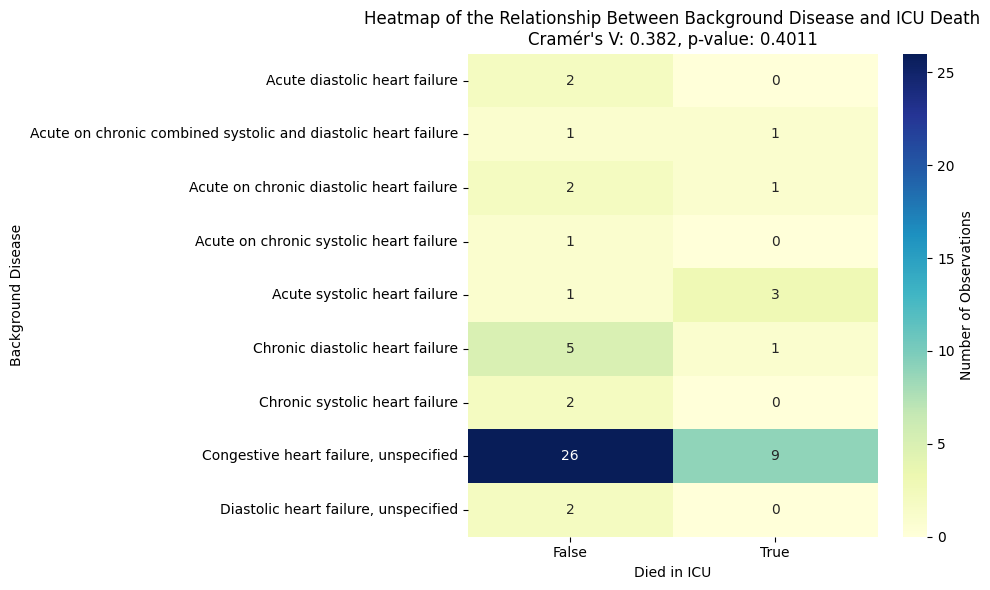

In [96]:
# Grouping to avoid duplicate entries per subject and background disease
df_grouped = df.groupby(['subject_id', 'background_disease'], as_index=False)['died_in_icu'].max()

# Creating the contingency table
contingency_table = pd.crosstab(df_grouped['background_disease'], df_grouped['died_in_icu'])

# Performing the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Calculating Cramér’s V
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

# Creating a heatmap graph
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu", cbar_kws={'label': 'Number of Observations'})
plt.title(f"Heatmap of the Relationship Between Background Disease and ICU Death\nCramér's V: {cramers_v:.3f}, p-value: {p:.4f}")
plt.xlabel("Died in ICU")
plt.ylabel("Background Disease")
plt.tight_layout()
plt.show()


# Finding & Conclusion:
 * The condition is more common in white ethnicity.
 * The condition is more common in females than in males.
 * The condition is more common in older ages (60+).
 * There are outliers that might affect the results, such as:
   * young patients constitute a small amount of the overall patients and their metrics might add bias to the results.
   * patients posses multiple background diseases, which makes it harder to recognize which of the disease affects more the results.
 * We recognized that patients in ICU who went through a arterial blood pressure, have above 50% death rate.
 
# Further steps we would take to improve the analysis: 
 * add more data.
 * check move interactions between different features.
 * subgroup analysis 
 * feature engineering